In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.api as sm

## Partial Regression Plot

- 1. 특정한 독립변수를 제외한 나머지 독립변수들로 종속변수를 선형회귀하여 잔차를 구한다.
- 2. 나머지 독립변수들로 특정한 독립변수를 선형회귀하여 잔차를 구한다.
- 3. 독립변수 잔차를 독립변수로 종속변수 잔차를 종속변수로 하여 선형회귀를 한다.
- 이렇게 구한 값들을 스캐터 플롯으로 나타낸 것이 Partial Regression Plot 이다.

In [3]:
from sklearn.datasets import load_boston
boston = load_boston()
dfX0 = pd.DataFrame(boston.data,columns=boston.feature_names)
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(boston.target,columns=['MEDV'])
df = pd.concat([dfX,dfy],axis=1)
model_boston = sm.OLS(dfy,dfX)
result_boston = model_boston.fit()

- 1. OLS 클래스 객체 생성, 이 명령을 실행하기 전에 sm에서는 add_constant를 통해서 bias augmentation을 해주어야 합니다.
- 2. fit method로 모형 추정

In [12]:
print(result_boston.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Wed, 27 Jun 2018   Prob (F-statistic):          6.95e-135
Time:                        18:13:31   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4911      5.104      7.149      0.0

하나의 변수에 대해 plot_regerss_exog 명령을 실행하면 partial regression plot을 보여줍니다.

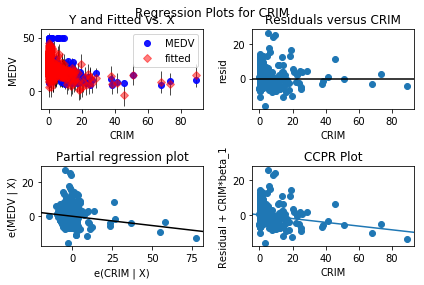

In [5]:
fig = sm.graphics.plot_regress_exog(result_boston,'CRIM')

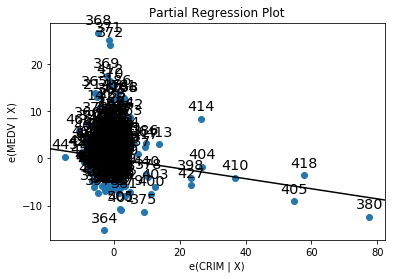

In [13]:
p, resids = sm.graphics.plot_partregress('MEDV','CRIM',\
                                         list(set(df.columns).difference(set(["MEDV", "CRIM"])))\
                                         ,data=df, ret_coords=True)
plt.show()

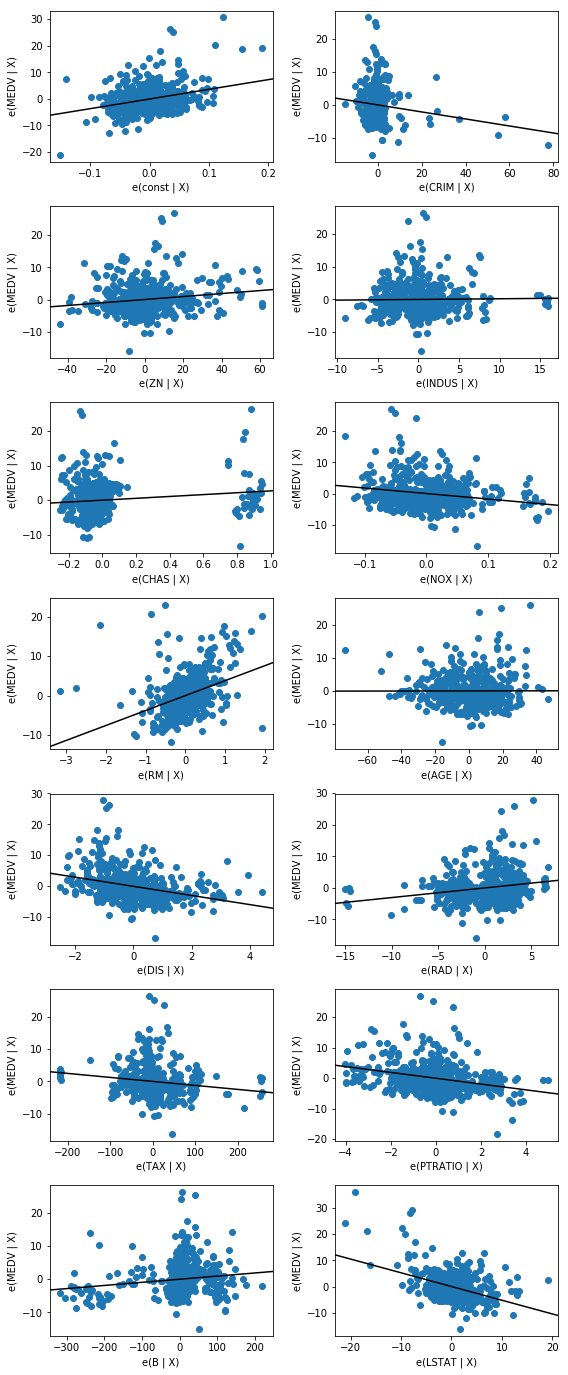

In [15]:
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_partregress_grid(result_boston, fig=fig)
fig.suptitle("")
plt.show()

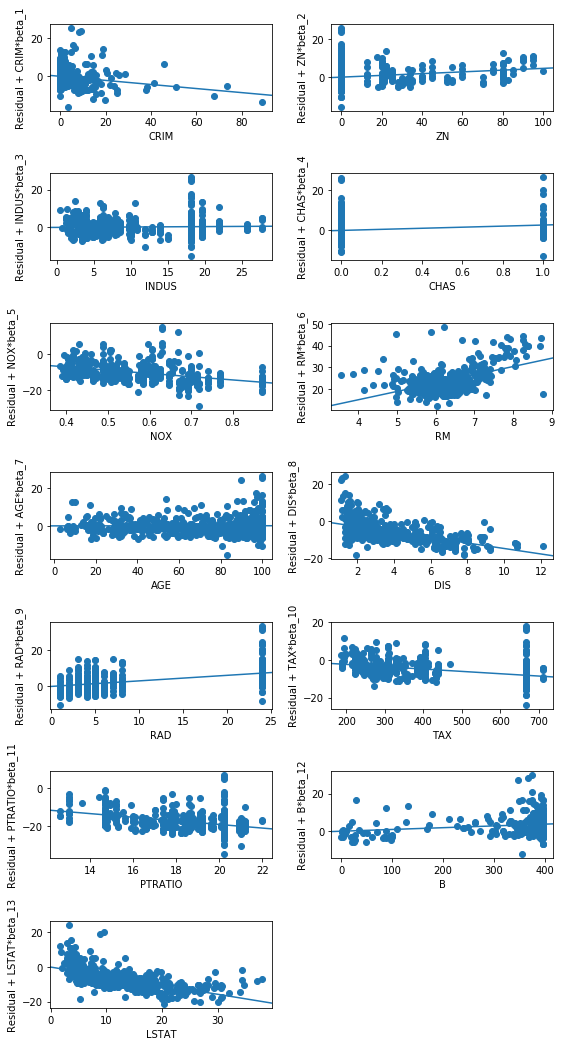

In [17]:
fig = plt.figure(figsize=(8, 15))
sm.graphics.plot_ccpr_grid(result_boston, fig=fig)
fig.suptitle("")
plt.show()

# 부트스트래핑 , 확률론적 선형회귀모형
- OLS 를 사용하면 데이터에 대한 확률론적인 가정없이도 최적의 가중치를 계산할 수 있다.
- 계산한 가중치에 대한 신뢰도를 확인할 방법이 필요하다.

In [18]:
from sklearn.datasets import make_regression

X0 , y, coef = make_regression(n_samples=100, n_features = 1, noise =20,\
                              coef=True, random_state=0)
coef

array(42.38550486)

In [19]:
dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()

In [24]:
result.params

const    -1.628364
X1       42.853356
dtype: float64

In [25]:
%%time
N = 1000
params_c = np.zeros(N)
params_x1 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True)
    dfX2 = dfX.iloc[idx, :]
    dfy2 = dfy.iloc[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_c[i] = r.params.const
    params_x1[i] = r.params.X1

CPU times: user 5.28 s, sys: 63.3 ms, total: 5.34 s
Wall time: 1.35 s


/home/hskimim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/hskimim/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


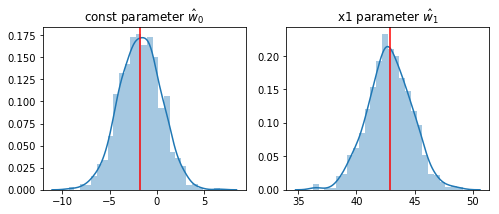

In [26]:
plt.figure(figsize=(8, 3))

ax1 = plt.subplot(121)
sns.distplot(params_c, ax=ax1)
plt.axvline(params_c.mean(), c='r')
plt.title("const parameter $\hat{w}_0$")

ax2 = plt.subplot(122)
sns.distplot(params_x1, ax=ax2)
plt.axvline(params_x1.mean(), c='r')
plt.title("x1 parameter $\hat{w}_1$")
plt.show()

## 확률론적 선형회귀모형
- 오차의 분포에 대한 가정
    - 선형 정규 분포 가정
    - 외생성 가정
    - 조건부 독립 가정
- 독립 변수에 대한 가정

### 1. 선형 정규 분포 가정
- 이 가정은 오차의 분포가 선형 정규 분포를 띈다는 가정이다.
- 기존의 종속 변수는 기댓값이 독립 변수의 선형 조합이고 고정된 분산값을 가지는 것이엿는데, 이를 오차(disturbance) 개념으로 변환하면 더 간단하게 표현할 수 있다.
- 애초에 disturbance가 종속 변수에 독립 변수의 선형 조합을 뺀 것이므로 기댓값이 0이 되고 고정된 분산값으로 그대로가 되어서 정규 분포 가정이 기댓값 = 0, 분산 = 고정된 분산이 된다.

### 2. 외생성 가정
- 오차의 기댓값은 독립 변수의 크기에 상관없이 항상 0이라고 가정한다. 
- 오차의 무조건부 기댓값이 0이다. (독립 변수와 상관관계가 없기 때문이다.)
- 오차와 독립변수와의 상관계수가 0이다. (무상관관계)

### 조건부 독립 가정
- 다른 샘플이 가지는 각각의 오차의 공분산 값은 독립 변수와 관계없이 항상 0이 된다.
- 서로 다른 샘플은 서로 독립이라는 과정과 같다.
- `Cov[epsilon] = E[ep ep.T] = sigma_square * I`
- 위의 식이 성립하는 이유는 샘플들이 독립이고 각 샘플들이 가지는 오차도 독립이기 때문에, 서로 다른 샘플들이 가지는 다른 오차들의 곱의 기댓값(공분산)은 0이 된다. 따라서 대각성분만 남게 되고 이는 자승값이므로 분산이 된다.

### 독립 변수에 대한 가정
- 독립 변수의 특징 행렬은 항상 full-rank이여야 한다.
- 즉, 독립 변수에서 서로 독립인 성분이 독립 변수의 수만큼 존재해야 한다.(linear independent)
- 이 조건이 성립해야만, X.T *X (covariance matrix)의 inverse 또한 full-rank가 되어서 존재하게 된다.

### 잔차의 분포
- 여기서는 잔차(residual)과 오차(error)의 차이점을 알고 들어가야 된다.
- 확률론적 선형 회귀모형에 따르면 회귀분석에서 생기는 잔차 `e = y-W.T * x` 도 정규분포를 따른다.(위의 오차의 분포에 대한 가정으로 선형 정규 분포를 따른다고 가정하였다.)
- 이전에 실제 값 y와 잔차 e의 관계성을 나타내는 residual matrix (M)에 대해서 이야기 한적이 있다.
- `e = y - y_hat = y - Hy = (I-H)y = My`
- `e = My = M(Xw + error) = MXw + M*error`
- 계산을 하게 되면 MX = 0 이 된다. (실제로 M을 풀어서 계산을 하면 정말로 0 이 된다.)
- 따라서 `e = M * resid` 오차 * residual matrix = 잔차이다.
- `잔차 e는 오차 epsilon 의 linear transform이다.`
- 따라서 정규 분포의 선형 변환은 마찬가지로 정규 분포이므로 잔차도 정규 분포를 따른다.

### 회귀 계수의 표준 오차
- 가중치의 예측치 w_hat도 정규 분포 확률 변수인 오차의 선형 변환이므로 정규분포를 따른다.
- 가중치의 예측치의 기댓값은 가중치와 같다. 따라서 w_hat은 w의 비편향 추정값이다.
- w_hat의 공분산(Cov[w_hat])은 `sigma_square * ( X.T * X).inv` 여기서 시그마 자승은 분산을 의미한다.
- 그런데 오차(disturbance)의 분산은 알지 못하므로 다음과 같이 잔차의 분산으로부터 추정을 한다.
- `s^2 = (e.T * e)/(N-K) = RSS/(N-K)`
- N : 표본 데이터의 수, K : 모수의 갯수
- w_hat 의 공분산은 `s2* ( X.T * X).inv` 가 된다.
- 이 공분산 행렬에서 우리가 원하는 값은 분산, 즉 공분산 행렬의 대각성분이다.
- 이 대각성분의 root를(표준편차) `회귀 계수의 표준 오차`라고 한다.
- 실제 가중치 계수와 우리가 추정한 가중치 계수의 차이를 표준 오차로 나눈 값
- 즉 정규화된 모수 오차는 자유도가 N-K인 표준 student t-distribution을 따른다.
- `(w_i - w_hat) / s*e_i ~t_N-K`

### 단일 계수 t- 검정
- 정규화된 모수 오차를 검정 통계량으로 사용하면 `w_i가 0인지 아닌지`에 대한 검정을 실시할 수 있다.

### Lost-of-Fit 검정(회귀 분석 F-검정)
- 개별 개수가 아닌 `전체 회귀 계수가 모두 의미가 있는지 확인`하는 경우에 사용한다.